In [2]:
# Library Import

# import jpype, jaydebeapi
import os, sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Opthon for jupyter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

In [4]:
def saveDataToCSV(file_path, data):
    data.to_csv(file_path, encoding = 'UTF-8', header = True, index = False)

In [5]:
def readFile(file_path):
#     file = open(file_path, 'r', encoding='UTF-8')
#     data = file.readlines().toString()
#     file.close()
    data = Path(file_path).read_text()
    return data

In [6]:
def startJVM():
    jar = os.getcwd()+'/lib/ojdbc6.jar'
    args = '-Djava.class.path=%s' % jar
    jvm_path = jpype.getDefaultJVMPath()
    jpype.startJVM(jvm_path, args)

In [7]:
def getDataFromDatabase(sql):
    query = None
    if(jpype.isJVMStarted()):
        print('JVM Already started')
    else:
        startJVM()
        
    query = readFile(sql)
    print(query)

    conn = jaydebeapi.connect('oracle.jdbc.driver.OracleDriver', 'jdbc:oracle:thin:CUI_APP/cui1234app@10.217.231.120:1524:TE2CUI1')
    curs = conn.cursor()
    curs.execute(query)
    data = pd.read_sql(query,conn)
    return data 

In [8]:
# 대기 중 공정 숫자 체크

def calculWaiting(row):
    temp_cnt = 0    
    for i in row[13:]:
            cnt2 = i.count('_0_')
            cnt3 = i.count('_3_')
            cnt5 = i.count('_5_')
            cnt6 = i.count('_6_')
            temp_cnt += cnt2
            temp_cnt += cnt3
            temp_cnt += cnt5
            temp_cnt += cnt6
    return temp_cnt

In [9]:
def correctDataRDD(row):
    if(int(row.OPN_HOPE_DATE[:4]) > 2100):
        return row.OPN_HOPE_DATE.replace(row.OPN_HOPE_DATE[:4], '2020')
    else:
        return row.OPN_HOPE_DATE

def correctDataRRDD(row):
    if(int(row.RMVL_HOPE_DATE[:4]) > 2100):
        return row.RMVL_HOPE_DATE.replace(row.RMVL_HOPE_DATE[:4], '2020')
    else:
        return row.RMVL_HOPE_DATE
        

In [10]:
def getAbnormalPairList(data):
    all_orderType_list = pna_data_enrich.ORDR_TYPE_ID.tolist()
    all_orderType_set= set(all_orderType_list)
    abnormal_pair = []

    for i in all_orderType_set:
            temp_cnt = 0
            for j in all_orderType_set:
                if(i in j):
                    if('D4' not in j):
                        temp_cnt += 1
            if(temp_cnt > 1):
#                 print(i, temp_cnt)
                abnormal_pair.append(i)
    return abnormal_pair

In [11]:
def calculateServiceActStatus(row):
    sa_status = row['SA']
    sa_list =sa_status.split('-')
    sa_result = list() 
    lbcs, lnod, lida, lmen = '','','',''
    
    for sa_status in sa_list:
        if('LBCS' in sa_status):
            lbcs = sa_status
        elif('LNOD' in sa_status):
            lnod = sa_status
        elif('LIDA' in sa_status):
            lida = sa_status
        elif('LMEN' in sa_status):
            lmen = sa_status

    if(len(lbcs) > 0):
        sa_result.append(lbcs)
    if(len(lnod) > 0):
        sa_result.append(lnod)
    if(len(lida) > 0):
        sa_result.append(lida)
    if(len(lmen) > 0):
        sa_result.append(lmen)
    if(len(sa_result) < 1):
        sa_result.append('NONE')
         
    return('-'.join(sa_result))    


In [12]:
def calculateLabel(row):
    resultSet = set()
    label = row['Label']
    
    for i in label:
        for j in i:
            resultSet.add(j)
    resultList = list(resultSet)
    
    if(len(resultList) < 1):
        resultList.append('NONE')
    
    return resultList

In [14]:
# Save Data from Database
sysdate = datetime.today().strftime('%Y%m%d%H%M%S')
SQL_PATH = './sql/AI_Assistant_EDA_PNA_normal.sql'
DATA_PATH = './data'
fileName =  'AI_SIT_PNA_normal_v'+sysdate+'.csv'

# data = getDataFromDatabase(SQL_PATH)
# saveDataToCSV(DATA_PATH + '/' + fileName, data)

# 1. start of analysis

## 1.1 PnA

### 1.1.1 File read

In [15]:
# read data from csv file
# fileName = 'AI_PRD_PNA_normal_v20200928090000.csv'
fileName = 'AI_SIT_PNA_normal_v20200928134000.csv'
input = pd.read_csv(DATA_PATH+'/'+fileName)

In [16]:
pna_data = input.copy()

In [17]:
# get basic info
pna_data.describe()
pna_data.info()
pna_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 29 columns):
QUERY_DATE              10020 non-null object
CUST_ORDR_NO            10020 non-null object
CUST_ORDR_VER_NO        10020 non-null int64
ORDR_COMPOSI_IDFY_ID    10020 non-null object
LOB                     10020 non-null object
ORDR_TYPE_ID            10020 non-null object
CONUTC                  1891 non-null object
PROD_ID                 10019 non-null object
PROD_ORDR_SEQ           10020 non-null object
OBDNG_ID                10020 non-null object
FIRST_CRET_DT           10020 non-null object
LAST_CHG_DT             10020 non-null object
OPN_HOPE_DATE           5629 non-null object
RMVL_HOPE_DATE          4428 non-null object
ICIS_CMPLN_DATE         236 non-null object
LAST_PRCS_EXEC          9994 non-null object
ORRE                    10012 non-null object
PRDI                    9927 non-null object
LORD                    5889 non-null object
PHRD                    13

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,NaN,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,NaN,2011-08-19 16:00:00,NaN,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LIDA_CP-
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,NaN,NaN,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,NaN,NaN,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,RECO_2_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,NaN,NaN,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,RECO_0_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LIDA_CP-
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,NaN,NaN,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1.2 결측치 처리

In [18]:
pna_data.tail()

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA
10015,2020-09-28 13:41:45,R02471TT279,1,R02471TT279,PSTN,TT,NaN,0501,10-10068639806,R02471,2020-09-16 14:32:03,2020-09-16 14:32:53,2020-09-16 14:31:42,2020-09-16 14:31:42,2020-09-16 14:32:53,2020-09-16 14:32:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JUJO_2_OKEY,NaN,FUCO_2_OKEY,MAUP_2_OKEY,ORCN_2_OKEY,NaN
10016,2020-09-28 13:41:45,SUSPDAIPTV40601,1,SUSPDAIPTV40601,IPTV,VA,NaN,0701,10-68021873359,R02471,2020-06-01 16:45:08,2020-09-16 14:31:52,2017-10-27 14:00:00,NaN,NaN,2020-09-16 14:31:48,ORRE_2_OKEY,PRDI_2_OKEY,LORD_3_LORD997,NaN,NaN,WODI_2_OKEY,REAC_2_OKEY,NaN,NaN,FUCO_0_OKEY,NaN,NaN,LIDA_ST-LMEN_MENE0004-
10017,2020-09-28 13:41:45,SUSPDAIPTV80021,1,SUSPDAIPTV80021,IPTV,VA,NaN,0701,10-68021873359,R02471,2020-06-02 11:59:06,2020-09-16 17:41:09,2017-10-27 14:00:00,NaN,NaN,2020-09-16 17:41:08,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,NaN,WODI_5_OKEY,REAC_3_REAC044,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LMEN_MENE0004-
10018,2020-09-28 13:41:45,SUSPDAIPTV80280,1,SUSPDAIPTV80280,IPTV,VA,NaN,0701,10-68021873359,R02471,2020-06-02 12:02:18,2020-09-16 17:43:23,2017-10-27 14:00:00,NaN,NaN,2020-09-16 17:43:22,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,NaN,WODI_2_OKEY,REAC_3_REAC044,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LMEN_MENE0004-
10019,2020-09-28 13:41:45,TESTSLCLI603052,11,TESTSLCLI603052,IPTV,V1,NaN,0701,10-64097325094,R02471,2020-06-04 18:01:07,2020-09-17 18:36:51,NaN,2020-05-29 00:00:00,2020-09-17 18:36:50,2020-09-17 18:36:47,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAUP_2_OKEY,ORCN_2_OKEY,LIDA_ST-LMEN_ST-


In [19]:
# MAX_DATE = '99/12/31 23:59:59'
MAX_DATE = '2099-12-31 23:59:59'

In [20]:
data = pna_data.isna().sum()
null_column_list = data[data > 0].index
'''
['PROD_ID', 'OPN_HOPE_DATE', 'RMVL_HOPE_DATE', 'ICIS_CMPLN_DATE',
       'LAST_PRCS_EXEC', 'ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI',
       'REAC', 'JUJO', 'SWBO', 'FUCO', 'MAUP', 'ORCN', 'SA']
'''
# dropna
pna_data.dropna(subset=["PROD_ID"], inplace= True)
pna_data.dropna(subset=["LAST_PRCS_EXEC"], inplace= True)

## fill data
# date column
pna_data['OPN_HOPE_DATE'].fillna(pna_data['RMVL_HOPE_DATE'], inplace= True)
pna_data['RMVL_HOPE_DATE'].fillna(pna_data['OPN_HOPE_DATE'], inplace= True)
pna_data['ICIS_CMPLN_DATE'].fillna(MAX_DATE, inplace= True)

# function column

# apply 함수를 사용하여, 각 column에 적용
## not work pna_data.apply(lambda x: x.fillna('NONE_NONE_NONE') if pna_data.columns  != 'SA' else x.fillna('NONE'))

func_column_list = [i for i in pna_data.iloc[:,13:-1].columns]

for i in func_column_list:
    pna_data[i].fillna('NONE_NONE_NONE', inplace = True)

pna_data['SA'].fillna('NONE', inplace = True)

In [21]:
pna_data.head()
# data = pna_data.isna().sum()
# null_column_list = data[data > 0].index
# null_column_list

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,NaN,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,2011-08-19 16:00:00,2011-08-19 16:00:00,2099-12-31 23:59:59,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,2015-10-26 00:00:00,2099-12-31 23:59:59,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,2014-05-26 18:00:00,2099-12-31 23:59:59,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_0_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,2014-06-14 18:00:00,2099-12-31 23:59:59,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE


### 1.1.3 Data Enrich

In [22]:
pna_data_enrich = pna_data.copy()
pna_data_enrich['WAITING_NUM'] = pna_data.apply(lambda row: calculWaiting(row), axis=1)

In [23]:
pna_data_enrich['SA_FINAL'] = pna_data_enrich.apply(lambda row: calculateServiceActStatus(row), axis=1)

In [24]:
pna_data_enrich.loc[pna_data_enrich['SA_FINAL'] == 'NONE']

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,2015-10-26 00:00:00,2099-12-31 23:59:59,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,2014-06-14 18:00:00,2099-12-31 23:59:59,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
5,2020-09-28 13:41:45,14177A408541091,1,14177A408541091-1055586,PSTN,B1,NaN,099S,10-11188064451-1055586,R02471,2014-06-26 10:41:19,2020-09-21 10:45:32,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2016-01-07 13:35:18,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
6,2020-09-28 13:41:45,14177A408541391,1,14177A408541391-1055589,PSTN,B1,NaN,099S,10-11188064481-1055589,R02471,2014-06-26 10:41:21,2020-09-21 10:45:59,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2014-06-26 10:42:50,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_7_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
8,2020-09-28 13:41:45,1430394046669A0,12,1430394046669-12017256550,INTERNET,OLOK,06525974,0822,20-12017256550,R03457,2020-09-16 18:16:50,2020-09-16 18:16:50,2020-09-18 14:00:00,2020-09-18 14:00:00,2099-12-31 23:59:59,2020-09-16 18:16:50,ORRE_2_OKEY-ORRE_2_OKEY,PRDI_0_OKEY-PRDI_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,2,NONE
9,2020-09-28 13:41:45,15086B417732891,1,15086B417732891-1000360,PSTN,KG,NaN,099S,10-11188292911-1000360,R02402,2015-03-27 11:47:53,2020-09-24 16:47:01,2015-03-27 11:00:00,2015-03-27 11:00:00,2099-12-31 23:59:59,2020-09-24 15:11:47,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_0_OKEY,WODI_2_OKEY,REAC_2_OKEY,JUJO_0_OKEY,NONE_NONE_NONE,FUCO_0_OKEY,MAUP_1_OKEY,ORCN_2_OKEY,NONE,3,NONE
14,2020-09-28 13:41:45,171555D0102859N,9,171555D010285-11430261180,INTERNET,X2,62,099S,10-11430261180,R00166,2017-06-04 16:12:14,2020-09-07 15:05:16,2017-06-04 09:00:00,2017-06-04 09:00:00,2099-12-31 23:59:59,2017-09-25 13:54:53,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,REAC_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,1,NONE
15,2020-09-28 13:41:45,17209HJ86099491,2,17209HJ86099491-1122012-Reversal,PSTN,B1,NaN,0501,10-11591701771-1122012-Reversal,R00436,2020-09-15 16:04:07,2020-09-15 16:04:38,2020-09-15 16:03:26,2020-09-15 16:03:26,2099-12-31 23:59:59,2020-09-15 16:04:35,ORRE_2_OKEY,PRDI_2_OKEY,LORD_3_LORD997,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,1,NONE
35,2

In [25]:
# pna_data_enrich['QUERY_DATE'] = pd.to_datetime(pna_data_enrich['QUERY_DATE'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['OPN_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['OPN_HOPE_DATE'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['FIRST_CRET_DT'] = pd.to_datetime(pna_data_enrich['FIRST_CRET_DT'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['LAST_CHG_DT'] = pd.to_datetime(pna_data_enrich['LAST_CHG_DT'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['RMVL_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['RMVL_HOPE_DATE'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['ICIS_CMPLN_DATE'] = pd.to_datetime(pna_data_enrich['ICIS_CMPLN_DATE'], format = '%y/%m/%d %H:%M:%S')

# check and replace datetime
pna_data_enrich['OPN_HOPE_DATE'] = pna_data_enrich.apply(lambda row: correctDataRRDD(row), axis= 1)
pna_data_enrich['RMVL_HOPE_DATE'] = pna_data_enrich.apply(lambda row: correctDataRDD(row), axis= 1)

pna_data_enrich['QUERY_DATE'] = pd.to_datetime(pna_data_enrich['QUERY_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['OPN_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['OPN_HOPE_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['RMVL_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['RMVL_HOPE_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['FIRST_CRET_DT'] = pd.to_datetime(pna_data_enrich['FIRST_CRET_DT'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['LAST_CHG_DT'] = pd.to_datetime(pna_data_enrich['LAST_CHG_DT'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['ICIS_CMPLN_DATE'] = pd.to_datetime(pna_data_enrich['ICIS_CMPLN_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['LAST_PRCS_EXEC'] = pd.to_datetime(pna_data_enrich['LAST_PRCS_EXEC'], format = '%Y-%m-%d %H:%M:%S')

In [26]:
pna_data_enrich['sysDtLastChgDtDelta'] = (pna_data_enrich['QUERY_DATE'] - pna_data_enrich['LAST_CHG_DT']).astype('timedelta64[m]')
pna_data_enrich['sysDtLastExecDtDelta'] = (pna_data_enrich['QUERY_DATE'] - pna_data_enrich['LAST_PRCS_EXEC']).astype('timedelta64[m]')
pna_data_enrich['hopeDtSysDtDelta'] = (pna_data_enrich['OPN_HOPE_DATE'] - pna_data_enrich['QUERY_DATE']).astype('timedelta64[m]')

# 이상치 처리
- 쌍명령 중 1개만 검색 된 것 제외 (트레이닝 데이터 온리)

In [27]:
abnormalPairList = getAbnormalPairList(pna_data_enrich)

In [28]:
pna_data_enrich = pna_data_enrich[~pna_data_enrich['ORDR_TYPE_ID'].isin(abnormalPairList)]

In [29]:
pna_data_enrich['ORDR_TYPE_ID'].value_counts()

SA      3434
SB      1939
V1      1053
SI       958
O1       625
OB       473
VI       267
S2       208
VA       149
OA       139
UA       115
U1        93
S1        70
VB        46
B1        45
VE        31
XI        28
UC        28
VF        25
OE        23
WB        20
OF        19
XHXG      19
N2        17
U2        17
J1        14
X1        12
VC        12
O2        11
UI         9
SC         8
N3         8
C1         7
J2         7
UB         7
EO         6
X2         5
OLOK       5
A1         4
V2         4
TGRG       3
B3         3
XB         3
I4         2
XT         2
QBQA       2
VT         2
N1         2
E3         1
K9         1
ONOM       1
A2         1
M1         1
D2         1
TT         1
I6         1
L1         1
TLRL       1
L2         1
KG         1
KZ         1
BA         1
Name: ORDR_TYPE_ID, dtype: int64

# Anal

##### pna_data_enrich['column'].str.contains('abc') or pna_data_enrich['ORRE'].isin(['ORRE_2_OKEY', 'ORRE_2_OKEY-ORRE_2_OKEY'])

In [30]:
pna_data_group = pna_data_enrich.groupby(['LOB'])['CUST_ORDR_NO']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values('count')
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_data_groupAgg

,LOB,cnt,max,min
5,WIBRO,20,20268M13245619N,20249M13511609N
3,PSTN,130,R02471TT279,14120A001721891
1,IOT,269,20270K14884469N,190819V1281949N
0,INTERNET,1368,R02471TG874,14142A107439590
2,IPTV,1589,TESTSLCLI603052,18085FJ0677209N
4,SOIP,6617,20272B86481089N,11231G318317191


In [31]:
pna_data_group = pna_data_enrich.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values('count')
#column name change
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_data_groupAgg

,ORDR_TYPE_ID,cnt,max,min
29,ONOM,1,202479R6201869N,202479R6201869N
14,KG,1,15086B417732891,15086B417732891
13,K9,1,20245GN26261591,20245GN26261591
17,L2,1,20259EP53500691,20259EP53500691
18,M1,1,20259ET53501191,20259ET53501191
10,I6,1,20259GD53502091,20259GD53502091
15,KZ,1,20259GC53501991,20259GC53501991
16,L1,1,20259EP53500691,20259EP53500691
6,D2,1,20259GP53502291,20259GP53502291
38,TLRL,1,R02471TL132,R02471TL132


<BarContainer object of 62 artists>

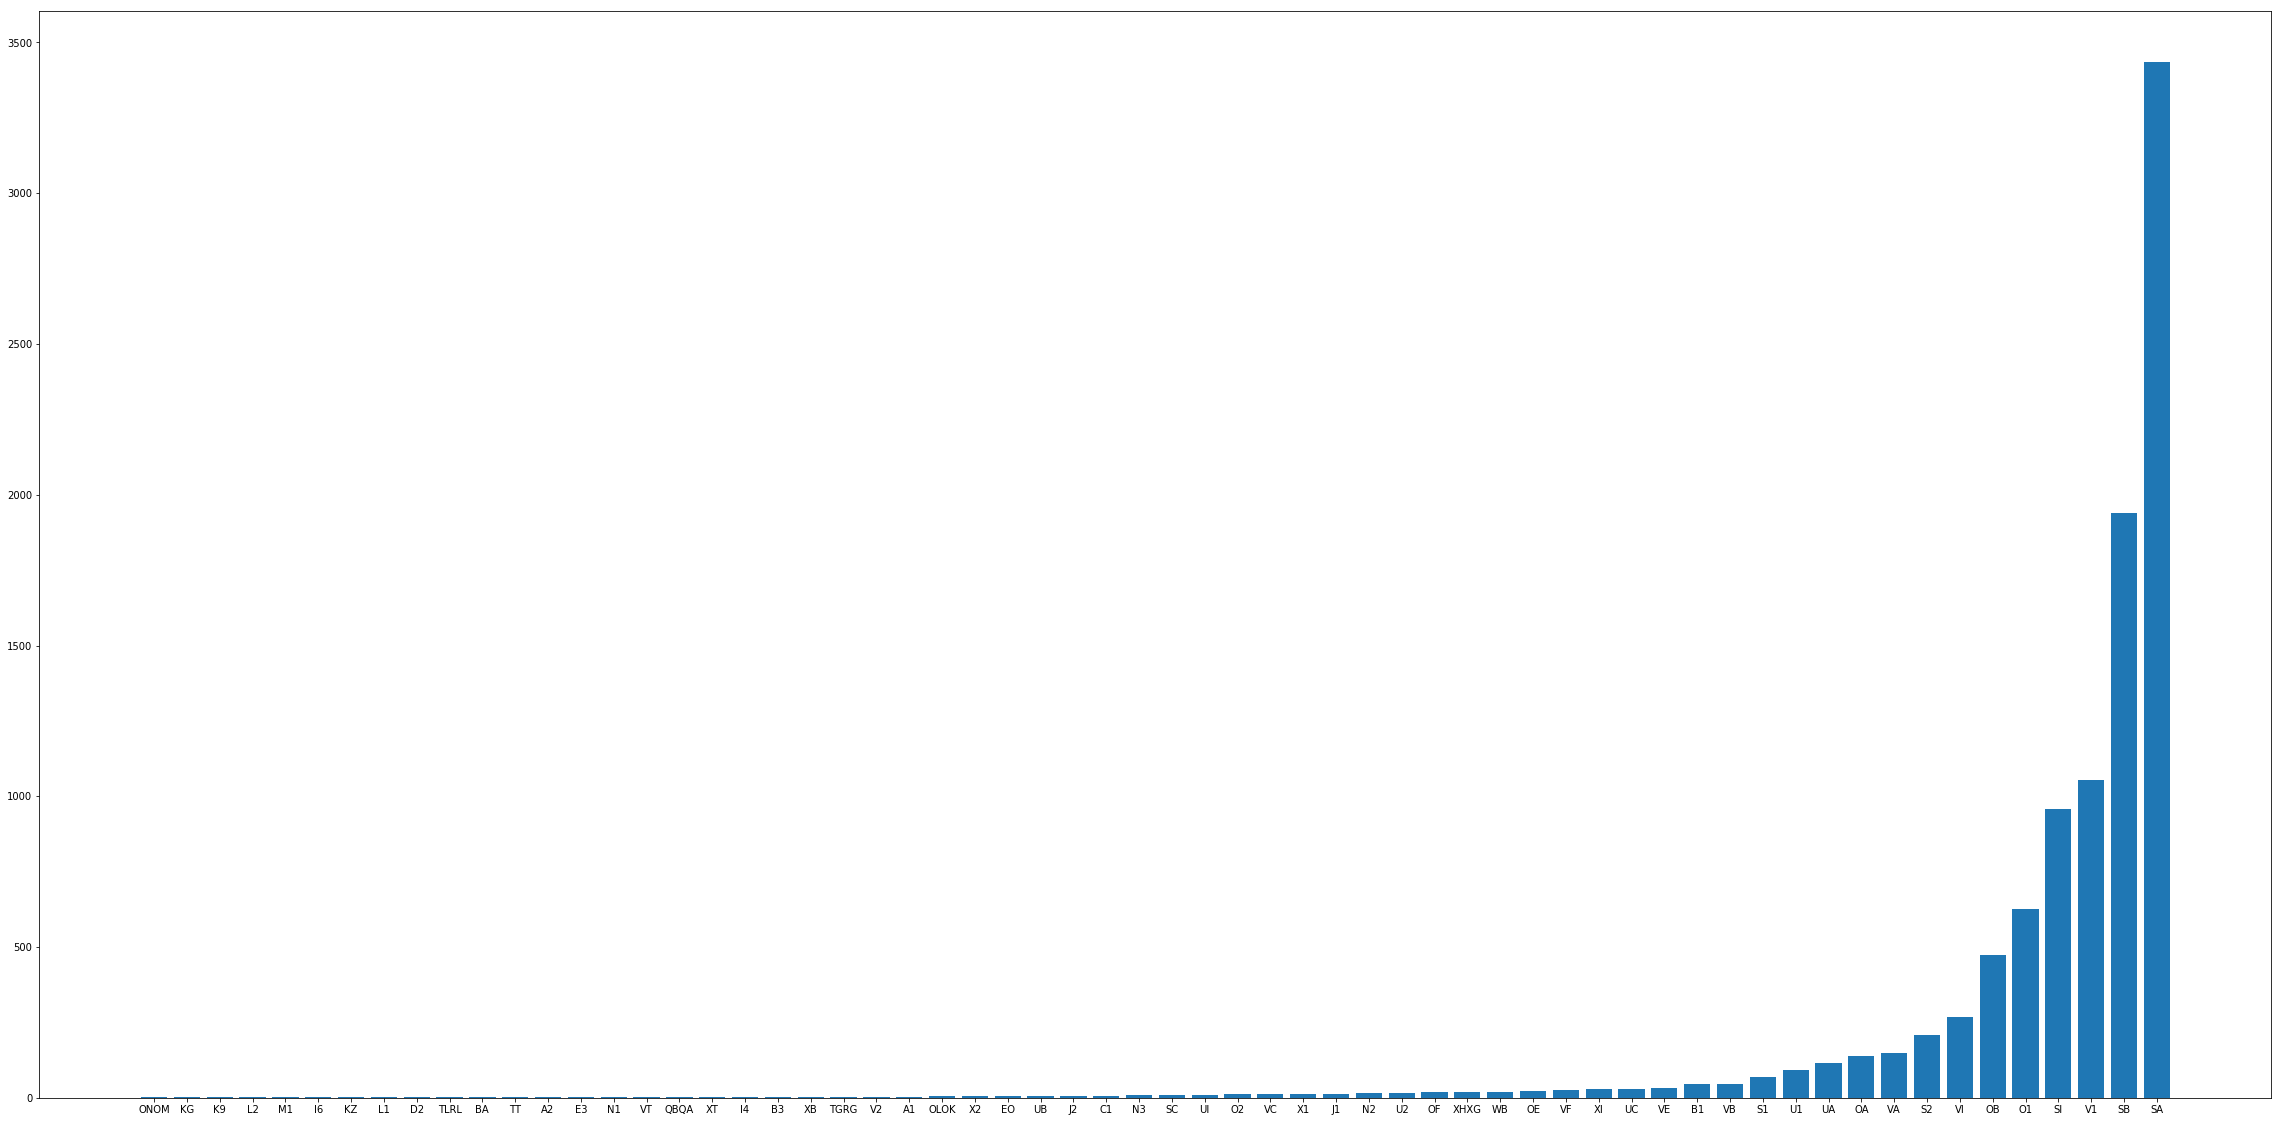

In [32]:
plt.figure(figsize=(40,20))
plt.bar(pna_data_groupAgg.ORDR_TYPE_ID, pna_data_groupAgg.cnt)

In [33]:
# Fucntion based

In [34]:
# pna_data_enrich = pna_data_enrich.loc[(pna_data['ORRE'] == 'ORRE_2_OKEY')  & (pna_data['PRDI'] == 'PRDI_0_OKEY') & (pna_data['LORD'] == 'NONE_NONE_NONE')  & (pna_data['REAC'] == 'NONE_NONE_NONE')
#                 & (pna_data['PHRD'] == 'NONE_NONE_NONE')  & (pna_data['WODI'] == 'NONE_NONE_NONE') & (pna_data['RECO'] == 'NONE_NONE_NONE')  
#                  & (pna_data['FUCO'] == 'NONE_NONE_NONE') & (pna_data['MAUP'] == 'NONE_NONE_NONE')]

# 4. 데이터 그룹핑
- 4.2.1 주요 데이터 : LOB 및 WorkOdrTypeCode 등의 Key로 그룹핑
- 4.2.2 공정 기반 : 공정 기반으로 그룹핑

## 4.1 주요 데이터


In [35]:
# 주요 데이터 - LOB
pna_group_lob = pna_data_enrich.groupby(['LOB'])['CUST_ORDR_NO']
pna_group_lob_agg = pna_group_lob.agg(['count','max','min']).reset_index().sort_values('count')
pna_group_lob_agg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_group_lob_agg

,LOB,cnt,max,min
5,WIBRO,20,20268M13245619N,20249M13511609N
3,PSTN,130,R02471TT279,14120A001721891
1,IOT,269,20270K14884469N,190819V1281949N
0,INTERNET,1368,R02471TG874,14142A107439590
2,IPTV,1589,TESTSLCLI603052,18085FJ0677209N
4,SOIP,6617,20272B86481089N,11231G318317191


In [36]:
# 주요 데이터 - 오더타입
pna_group_type = pna_data_enrich.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO']
pna_group_type_agg = pna_group_type.agg(['count','max','min']).reset_index().sort_values('count')
pna_group_type_agg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_group_type_agg

,ORDR_TYPE_ID,cnt,max,min
29,ONOM,1,202479R6201869N,202479R6201869N
14,KG,1,15086B417732891,15086B417732891
13,K9,1,20245GN26261591,20245GN26261591
17,L2,1,20259EP53500691,20259EP53500691
18,M1,1,20259ET53501191,20259ET53501191
10,I6,1,20259GD53502091,20259GD53502091
15,KZ,1,20259GC53501991,20259GC53501991
16,L1,1,20259EP53500691,20259EP53500691
6,D2,1,20259GP53502291,20259GP53502291
38,TLRL,1,R02471TL132,R02471TL132


## 4.2 공정

In [37]:
pna_group_func = pna_data_enrich.copy()
pna_group_func = pna_group_func.groupby(['LOB', 'ORDR_TYPE_ID', 'ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO','FUCO', 'MAUP', 'ORCN', 'SA_FINAL'])['CUST_ORDR_NO','ORDR_TYPE_ID','WAITING_NUM']
pna_group_func_agg = pna_group_func.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO', 'count')])
pna_group_func_agg.rename(columns = {'count': 'cnt'}, inplace = True)

pna_group_func_agg

LOB ORDR_TYPE_ID         ORRE            PRDI            LORD  \
                                                                          
0    INTERNET           O1  ORRE_2_OKEY  NONE_NONE_NONE  NONE_NONE_NONE   
170      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
171      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
173      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
174      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
175      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
176      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
335      SOIP           SC  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
181      IPTV           VF  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
182      IPTV           VF  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD700   
334      SOIP           SC  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
333      SOIP           SC  ORRE_2_OKEY     PRDI_0_OKEY  NONE_NONE_NONE   
189      IPTV           VI  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
167      IPTV           VC  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
191      IPTV           VI  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
196      IPTV           VT  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
197      PSTN           A1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
198      PSTN           A1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
199      PSTN           A1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
200      PSTN           A1  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD600   
201      PSTN           A2  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
202      PSTN           B1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
205      PSTN           B1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
208      PSTN           B1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
210      PSTN           B1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
212      PSTN           B1  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD997   
213      PSTN           B3  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
195      IPTV           VT  ORRE_2_OKEY     PRDI_0_OKEY  NONE_NONE_NONE   
163      IPTV           VB  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
161      IPTV           VB  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
336      SOIP           SC  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
340      SOIP           SI  ORRE_2_OKEY  NONE_NONE_NONE     LORD_2_OKEY   
126      IPTV           V1  ORRE_2_OKEY     PRDI_0_OKEY  NONE_NONE_NONE   
130      IPTV           V1  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
339      SOIP           SI  ORRE_2_OKEY  NONE_NONE_NONE     LORD_2_OKEY   
132      IPTV           V1  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD074   
133      IPTV           V1  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD700   
136      IPTV           V2  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD700   
137      IPTV           VA  ORRE_2_OKEY  NONE_NONE_NONE     LORD_2_OKEY   
138      IPTV           VA  ORRE_2_OKEY     PRDI_0_OKEY     LORD_2_OKEY   
338      SOIP           SC  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD700   
140      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
141      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
142      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
144      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
146      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
147      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
148      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
149      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
150      IPTV           VA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
..        ...          ...          ...             ...             ...   
192      IPTV           VI  ORRE_2_

In [38]:
pna_group_func_agg['Label'] = ''
pna_group_func_agg['Label'] = pna_group_func_agg['Label'].apply(list)

# 5. 오더분석
- 오더 분석은 정상, 에러(PNA), 오류(Defect)오더로 분류 한다.
- 기본적인 분석은 공정간 Grouping을 통한 유형 분류를 통해 수행한다.
- 다양한 오더 유형이 있는 공정 유형이 General하지 않은 경우에는 Detail한 분석을 수행한다.
 (공정 상태 조건을 통한 오더 정보 수집)


## 5.1 정상 오더 분류
### 5.1.1 공통
### 5.1.2 LOB

## 5.2 비정상 오더 분류
### 5.2.1 공통
### 5.2.2 LOB

### 5.1.1 정상 오더 분류
- 오더 완료

In [39]:
# ORCN
func_groupAgg_normal_N0001 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('ORCN','')] == 'ORCN_2_OKEY-ORCN_2_OKEY') | ((pna_group_func_agg[('ORCN','')] == 'ORCN_2_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_7_OKEY']))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0001.index)].Label.apply(lambda x: x.append('N001') or x) 


# SWBO
func_groupAgg_normal_N0002 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('SWBO','')] == 'SWBO_0_OKEY-SWBO_0_OKEY') |  ((pna_group_func_agg[('SWBO','')] == 'SWBO_0_OKEY') & (pna_group_func_agg[('ORCN','')] == 'ORCN_2_OKEY'))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('SWBO','')] == 'SWBO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0002.index)].Label.apply(lambda x: x.append('N002') or x) 

# FUCO
func_groupAgg_normal_N0003 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (  
                                                      (pna_group_func_agg[('FUCO','')] == 'FUCO_0_OKEY-FUCO_0_OKEY') |  ((pna_group_func_agg[('FUCO','')] == 'FUCO_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('FUCO','')] == 'FUCO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0003.index)].Label.apply(lambda x: x.append('N003') or x) 

# JUJO
func_groupAgg_normal_N0004 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('JUJO','')] == 'JUJO_0_OKEY-JUJO_0_OKEY') |  ((pna_group_func_agg[('JUJO','')] == 'JUJO_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('JUJO','')] == 'JUJO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0004.index)].Label.apply(lambda x: x.append('N004') or x) 

# REAC
func_groupAgg_normal_N0005 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('REAC','')].isin(['REAC_6_OKEY-REAC_6_OKEY', 'REAC_0_OKEY-REAC_0_OKEY', 'REAC_0_OKEY-REAC_6_OKEY', 'REAC_6_OKEY-REAC_0_OKEY'])) |  ((pna_group_func_agg[('REAC','')].isin(['REAC_0_OKEY', 'REAC_6_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('REAC','')].isin(['REAC_0_OKEY','REAC_6_OKEY']))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0005.index)].Label.apply(lambda x: x.append('N005') or x) 

# RECO
func_groupAgg_normal_N0006 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('RECO','')] == 'RECO_0_OKEY-RECO_0_OKEY') |  ((pna_group_func_agg[('RECO','')] == 'RECO_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('RECO','')] == 'RECO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0006.index)].Label.apply(lambda x: x.append('N006') or x) 

# WODI
func_groupAgg_normal_N0007 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY-WODI_0_OKEY') |  ((pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY')))]

# WODI additional
func_groupAgg_normal_N0007 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY-WODI_0_OKEY') |  ((pna_group_func_agg[('WODI','')] == 'WODI_6_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('WODI','')] == 'WODI_6_OKEY')))]


pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0007.index)].Label.apply(lambda x: x.append('N007') or x) 

# PHRD
func_groupAgg_normal_N0008 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('PHRD','')] == 'PHRD_0_OKEY-PHRD_0_OKEY') |  ((pna_group_func_agg[('PHRD','')] == 'PHRD_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PHRD','')] == 'PHRD_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0008.index)].Label.apply(lambda x: x.append('N008') or x) 

# LORD
func_groupAgg_normal_N0009 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('LORD','')] == 'LORD_0_OKEY-LORD_0_OKEY') |  ((pna_group_func_agg[('LORD','')] == 'LORD_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('LORD','')] == 'LORD_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0009.index)].Label.apply(lambda x: x.append('N009') or x) 

# PRDI
func_groupAgg_normal_N0010 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('PRDI','')] == 'PRDI_0_OKEY-PRDI_0_OKEY') |  ((pna_group_func_agg[('PRDI','')] == 'PRDI_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PRDI','')] == 'PRDI_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0010.index)].Label.apply(lambda x: x.append('N010') or x) 




333                [N010]
195                [N010]
126                [N010]
138    [N003, N007, N010]
266                [N010]
283                [N010]
226                [N010]
243                [N010]
332                [N010]
314                [N010]
58                 [N010]
68                 [N010]
59                 [N010]
14     [N006, N007, N010]
98     [N003, N007, N010]
44                 [N010]
345                [N010]
119                [N010]
110                [N010]
71                 [N010]
135                [N010]
286                [N010]
179          [N001, N010]
165                [N010]
8                  [N010]
343                [N010]
315                [N010]
169                [N010]
66                 [N010]
73                 [N010]
93                 [N010]
54                 [N010]
80                 [N010]
180                [N010]
265                [N010]
15                 [N010]
115                [N010]
256                [N010]
344         

In [40]:
# Special condition for normal order
# Pair Order
func_groupAgg_normal_P0001 = pna_group_func_agg.loc[(pna_group_func_agg[('JUJO','')].isin(['JUJO_0_OKEY-JUJO_2_OKEY', 'JUJO_2_OKEY-JUJO_0_OKEY'])) & (pna_group_func_agg[('FUCO', '')] == 'FUCO_2_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0001.index)].Label.apply(lambda x: x.append('P0001') or x) 

func_groupAgg_normal_P0002 = pna_group_func_agg.loc[(pna_group_func_agg[('PRDI','')].isin(['PRDI_0_OKEY-PRDI_2_OKEY', 'PRDI_2_OKEY-PRDI_0_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0002.index)].Label.apply(lambda x: x.append('P0002') or x) 


func_groupAgg_normal_P0003 = pna_group_func_agg.loc[(pna_group_func_agg[('PRDI','')].isin(['PRDI_0_OKEY-PRDI_2_OKEY', 'PRDI_2_OKEY-PRDI_0_OKEY'])) & (pna_group_func_agg[('WODI', '')] == 'WODI_6_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0002.index)].Label.apply(lambda x: x.append('P0003') or x) 

func_groupAgg_normal_P0004 = pna_group_func_agg.loc[(pna_group_func_agg[('JUJO','')] == 'JUJO_2_OKEY-JUJO_0_OKEY') & (pna_group_func_agg[('REAC', '')] == 'REAC_2_OKEY-REAC_2_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0004.index)].Label.apply(lambda x: x.append('P0004') or x) 


Series([], Name: Label, dtype: object)

In [41]:
# Special condition for normal order
# Service activation waiting Order

# DEL Waiting
func_groupAgg_normal_S0001 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY') & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('SA_FINAL','')].str.contains('LNOD_ST'))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0001.index)].Label.apply(lambda x: x.append('S0001') or x) 

# IDMS Waiting
func_groupAgg_normal_S0003 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY')  & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('SA_FINAL','')] == 'LIDA_ST') & (pna_group_func_agg[('ORDR_TYPE_ID','')].isin(['UA','UB','U1','U2','UC','UI','SC', 'SI', 'SB']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0003.index)].Label.apply(lambda x: x.append('S0003') or x) 

# NO WODI and waiting for BSCMS
func_groupAgg_normal_S0004 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY') & (pna_group_func_agg[('PRDI', '')] == 'PRDI_2_OKEY') & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('WODI', '')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('SA_FINAL','')] == 'LBCS_ST')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0004.index)].Label.apply(lambda x: x.append('S0004') or x) 

# IPTV Timer
func_groupAgg_normal_S0005 = pna_group_func_agg.loc[(pna_group_func_agg[('LOB','')] == 'IPTV')  & (pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY') & (pna_group_func_agg[('PRDI', '')] == 'PRDI_2_OKEY') & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('WODI', '')].isin(['WODI_2_OKEY','NONE_NONE_NONE'])) & ~(pna_group_func_agg[('SA_FINAL','')].str.contains('LMEN_ST'))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0005.index)].Label.apply(lambda x: x.append('S0005') or x) 


171          [S0005]
173          [S0005]
175          [S0005]
181    [N001, S0005]
130          [S0005]
141          [S0005]
142    [N001, S0005]
146          [S0005]
148          [S0005]
186          [S0005]
188          [S0005]
162          [S0005]
187          [S0005]
131          [S0005]
Name: Label, dtype: object

In [42]:
# PNA Error 오더
# MAUP
func_groupAgg_error_E0001 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('MAUP','')].str.contains('MAUP_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('MAUP','')].str.contains('MAUP_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0001.index)].Label.apply(lambda x: x.append('E0001') or x) 

# FUCO
func_groupAgg_error_E0002 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('FUCO','')].str.contains('FUCO_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('FUCO','')].str.contains('FUCO_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0002.index)].Label.apply(lambda x: x.append('E0002') or x) 

# REAC
func_groupAgg_error_E0003 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('REAC','')].str.contains('REAC_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('REAC','')].str.contains('REAC_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0003.index)].Label.apply(lambda x: x.append('E0003') or x) 

# RECO
func_groupAgg_error_E0004 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('RECO','')].str.contains('RECO_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('RECO','')].str.contains('RECO_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0004.index)].Label.apply(lambda x: x.append('E0004') or x) 

# PHRD
func_groupAgg_error_E0005 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('PHRD','')].str.contains('PHRD_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PHRD','')].str.contains('PHRD_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0005.index)].Label.apply(lambda x: x.append('E0005') or x) 

# LORD
func_groupAgg_error_E0006 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('LORD','')].str.contains('LORD_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('LORD','')].str.contains('LORD_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0006.index)].Label.apply(lambda x: x.append('E0006') or x) 

# PRDI
func_groupAgg_error_E0007 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('PRDI','')].str.contains('PRDI_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PRDI','')].str.contains('PRDI_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0007.index)].Label.apply(lambda x: x.append('E0007') or x) 

# 미처리
func_groupAgg_error_EP001 = pna_group_func_agg.loc[(pna_group_func_agg[('WODI','')].str.contains('WODI_5'))]
                                                   
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_EP001.index)].Label.apply(lambda x: x.append('EP001') or x) 


149          [E0001, EP001]
150          [E0003, EP001]
301           [N001, EP001]
331    [N001, S0003, EP001]
341           [N003, EP001]
105    [N003, S0003, EP001]
20            [N006, EP001]
Name: Label, dtype: object

In [43]:
# Service activation error
func_groupAgg_error_ES001 = pna_group_func_agg.loc[((pna_group_func_agg[('LOB','')] == 'SOIP') & (pna_group_func_agg[('SA_FINAL','')].str.contains('LIDA_0')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_ES001.index)].Label.apply(lambda x: x.append('ES001') or x) 


Series([], Name: Label, dtype: object)

## 5.2 Defect
### 5.2.1 공통

In [44]:
# Amending 강제 준공
func_groupAgg_defect_D0001 = pna_group_func_agg.loc[(pna_group_func_agg[('PRDI','')].isin(['PRDI_7_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] == 0) 
                                                    & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0001.index)].Label.apply(lambda x: x.append('D0001') or x) 

func_groupAgg_defect_D0001 = pna_group_func_agg.loc[(pna_group_func_agg[('LORD','')].isin(['LORD_7_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] == 0) 
                                                   & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0001.index)].Label.apply(lambda x: x.append('D0001') or x) 

# ORRE Only
func_groupAgg_defect_D0002 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')].isin(['ORRE_2_OKEY', 'ORRE_2_OKEY-ORRE_2_OKEY']))  & (pna_group_func_agg[('PRDI','')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('LORD','')] == 'NONE_NONE_NONE')  & (pna_data_enrich['REAC'] == 'NONE_NONE_NONE')
                & (pna_group_func_agg[('PHRD','')] == 'NONE_NONE_NONE')  & (pna_group_func_agg[('WODI','')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('RECO','')] == 'NONE_NONE_NONE')  
                 & (pna_group_func_agg[('FUCO','')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('MAUP','')] == 'NONE_NONE_NONE')]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0002.index)].Label.apply(lambda x: x.append('D0002') or x) 

# No inprogress 
func_groupAgg_defect_D0003 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('SA_FINAL','')] == 'NONE')
                                                   & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0003.index)].Label.apply(lambda x: x.append('D0003') or x) 


# No inprogress 
func_groupAgg_defect_D0003 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('SA_FINAL','')] == 'NONE')
                                                   & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0003.index)].Label.apply(lambda x: x.append('D0003') or x) 


# LORD 001 status 
func_groupAgg_defect_DS001 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('LORD','')].str.contains('LORD_1_OKEY')) 
                                                     &  ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DS001.index)].Label.apply(lambda x: x.append('DS001') or x) 


316    [DS001]
Name: Label, dtype: object

In [45]:
### 5.2.2 LOB WIse

In [46]:
# IPTV
func_groupAgg_defect_DV001 = pna_group_func_agg.loc[(pna_group_func_agg[('LORD','')].isin(['LORD_2_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] == 0) 
                                                    & (pna_group_func_agg[('SA_FINAL','')].str.contains('LMEN_ST')) & (pna_group_func_agg[('ORCN','')] != 'ORCN_2_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DV001.index)].Label.apply(lambda x: x.append('DV001') or x) 
func_groupAgg_defect_DI001

NameError: name 'func_groupAgg_defect_DI001' is not defined

In [47]:
# Internet

# No inprogress 
func_groupAgg_defect_DI001 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('LOB','')] == 'INTERNET') 
                                                     & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DI001.index)].Label.apply(lambda x: x.append('DI001') or x) 

func_groupAgg_defect_DI001

LOB ORDR_TYPE_ID         ORRE            PRDI            LORD  \
                                                                         
0   INTERNET           O1  ORRE_2_OKEY  NONE_NONE_NONE  NONE_NONE_NONE   
42  INTERNET           OB  ORRE_2_OKEY     PRDI_2_OKEY     LORD_7_OKEY   
16  INTERNET           OA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
33  INTERNET           OA  ORRE_2_OKEY     PRDI_2_OKEY  NONE_NONE_NONE   

              PHRD            RECO            WODI            REAC  \
                                                                     
0   NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
42  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
16  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
33  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

              JUJO            SWBO            FUCO            MAUP  \
                                                                     
0   NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
42  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
16  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
33  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

              ORCN SA_FINAL CUST_ORDR_NO                                    \
                                     cnt              max              min   
0   NONE_NONE_NONE     NONE            1  20260HB3405119N  20260HB3405119N   
42  NONE_NONE_NONE  LIDA_ST            1  17341H41156339N  17341H41156339N   
16  NONE_NONE_NONE  LIDA_ST            1  170489A76979190  170489A76979190   
33  NONE_NONE_NONE  LIDA_ST            3  20247AJ6202509N  202479T6201909N   

   ORDR_TYPE_ID         WAITING_NUM                                 Label  
            cnt max min         cnt max min                                
0             1  O1  O1           1   0   0  [D0002, D0003, D0003, DI001]  
42            1  OB  OB           1   0   0                [D0001, DI001]  
16            1  OA  OA           1   0   0                       [DI001]  
33            3  OA  OA           3   0   0                       [DI001]

In [48]:
# SOIP & IOT

# No inprogress 
func_groupAgg_defect_DS001 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('LOB','')].isin(['IOT', 'SOIP']))
                                                    & (pna_group_func_agg[('PRDI','')] == 'PRDI_2_OKEY') 
                                                     & (pna_group_func_agg[('LORD','')] == 'NONE_NONE_NONE')  & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DS001.index)].Label.apply(lambda x: x.append('DS001') or x) 

func_groupAgg_defect_DS001

LOB ORDR_TYPE_ID         ORRE         PRDI            LORD  \
                                                                   
124   IOT           UI  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
277  SOIP           S2  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
310  SOIP           SA  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
109   IOT           UA  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
330  SOIP           SB  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   

               PHRD            RECO            WODI            REAC  \
                                                                      
124  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
277  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
310  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
109  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
330  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

               JUJO            SWBO            FUCO            MAUP  \
                                                                      
124  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
277  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
310  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
109  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
330  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

               ORCN         SA_FINAL CUST_ORDR_NO                   \
                                              cnt              max   
124  NONE_NONE_NONE          LIDA_ST            1  20247BJ6202889N   
277  NONE_NONE_NONE          LIDA_ST            1  202479L6199989N   
310  NONE_NONE_NONE  LBCS_ST-LNOD_ST            2  202540S5900589N   
109  NONE_NONE_NONE          LIDA_ST            3  20247AK6202539N   
330  NONE_NONE_NONE  LBCS_ST-LNOD_ST            7  20267GT5959879N   

                     ORDR_TYPE_ID         WAITING_NUM            Label  
                 min          cnt max min         cnt max min           
124  20247BJ6202889N            1  UI  UI           1   0   0  [DS001]  
277  202479L6199989N            1  S2  S2           1   0   0  [DS001]  
310  202540S5900439N            2  SA  SA           2   0   0  [DS001]  
109  202479U6201959N            3  UA  UA           3   0   0  [DS001]  
330  20267GT5959529N            7  SB  SB           7   0   0  [DS001]

In [50]:
pna_group_func_agg['Label'] = pna_group_func_agg.apply(lambda row: calculateLabel(row), axis = 1)
pna_group_func_agg.sort_values(['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO', 'FUCO', 'MAUP', 'ORCN', 'SA_FINAL'])
saveDataToCSV("./anal/pna_group_func_agg_E007.csv",pna_group_func_agg)

### Anaysis target orders

### 미완료 오더 중 진행 중 공정 Zero

In [ ]:
target_df = pna_data_enrich.loc[(pna_data_enrich['ORCN'] == 'NONE_NONE_NONE') & (pna_data_enrich['WAITING_NUM'] == 0)]

In [ ]:
pna_data_group = target_dt_dc002.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO', 'PROD_ID']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO','count')])
#.sort_values(pna_data_group.get_level_values(1) == 'count')
#column name change
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)

In [ ]:
pna_data_groupAgg.head()
# pna_data_groupAgg.columns = pna_data_groupAgg.columns.to_flat_index()

In [ ]:
pna_data_enrich.loc[(pna_data_enrich['ORCN'] == 'NONE_NONE_NONE') & (pna_data_enrich['WAITING_NUM'] == 0) & (pna_data_enrich['ORDR_TYPE_ID'] == 'SA')]

In [ ]:
### 희망일 초과 오더

In [ ]:
target_dt = pna_data_enrich.loc[(pna_data_enrich['hopeDtSysDtDelta'] < 0) & (pna_data_enrich['ORCN'] == 'NONE_NONE_NONE')]
target_dt = pna_data_enrich.loc[(pna_data_enrich['WAITING_NUM'] == 0) & (pna_data_enrich['ORCN'] == 'NONE_NONE_NONE') & (pna_data_enrich['sysDtLastExecDtDelta'] > 10 )]

In [ ]:
target_dt = target_dt.sort_values(by = ['LOB', 'ORDR_TYPE_ID', 'sysDtLastExecDtDelta','CUST_ORDR_NO'])
target_dt.head()

## Common defect

In [ ]:
# DC001-ORRE Only completed
target_dt_dc001 = pna_data_enrich.loc[(pna_data_enrich['ORRE'].isin(['ORRE_2_OKEY', 'ORRE_2_OKEY-ORRE_2_OKEY']))  & (pna_data_enrich['PRDI'] == 'NONE_NONE_NONE') & (pna_data_enrich['LORD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['REAC'] == 'NONE_NONE_NONE')
                & (pna_data_enrich['PHRD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['WODI'] == 'NONE_NONE_NONE') & (pna_data_enrich['RECO'] == 'NONE_NONE_NONE')  
                 & (pna_data_enrich['FUCO'] == 'NONE_NONE_NONE') & (pna_data_enrich['MAUP'] == 'NONE_NONE_NONE')]

# DC002-No in-progress component
target_dt_dc002 = pna_data_enrich.loc[(pna_data_enrich['sysDtLastExecDtDelta'] > 10) & (pna_data_enrich['WAITING_NUM'] == 0) & (pna_data_enrich['SA'] == 'NONE') & (pna_data_enrich['ORCN'] == 'NONE_NONE_NONE')
                                     & ~(pna_data_enrich['ORDR_TYPE_ID'].isin(['AW', 'BA','BQ','KF', 'QA']))
                                     ]
target_dt_dc002[target_dt_dc002['LOB']=='PSTN']

## LOB

## 1.1 Internet

In [ ]:
pna_data_enrich_int = pna_data_enrich.loc[(pna_data_enrich['LOB'] == 'INTERNET') & (~pna_data_enrich['ORDR_TYPE_ID'].isin(['XV', 'XQ', 'ON', 'XP']))]
pna_data_group = pna_data_enrich_int.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO', 'PROD_ID']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO','count')])
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)

### SOIP for labeling

In [ ]:
# defect list
# 1 ORRE Only
target_dt_d1 = target_dt.loc[(pna_data['ORRE'] == 'ORRE_2_OKEY')  & (pna_data['PRDI'] == 'NONE_NONE_NONE') & (pna_data['LORD'] == 'NONE_NONE_NONE')  & (pna_data['REAC'] == 'NONE_NONE_NONE')
                & (pna_data['PHRD'] == 'NONE_NONE_NONE')  & (pna_data['WODI'] == 'NONE_NONE_NONE') & (pna_data['RECO'] == 'NONE_NONE_NONE')  
                 & (pna_data['FUCO'] == 'NONE_NONE_NONE') & (pna_data['MAUP'] == 'NONE_NONE_NONE')]

target_dt_d1

In [ ]:
target_dt_sa = target_dt.loc[(pna_data_enrich['ORDR_TYPE_ID'] == 'SA')]

In [ ]:
target_dt_sa.group = target_dt_sa.groupby(['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO','FUCO', 'MAUP', 'ORCN'])

In [ ]:
target_data_group = target_dt_sa.groupby(['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO','FUCO', 'MAUP', 'ORCN', 'SA'])['CUST_ORDR_NO','ORDR_TYPE_ID','PROD_ID']
target_data_groupAgg = target_data_group.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO', 'count')])
#column name change
target_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)

target_data_groupAgg

# Common analysis tools

In [51]:
pna_data_enrich

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL,sysDtLastChgDtDelta,sysDtLastExecDtDelta,hopeDtSysDtDelta
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,NaN,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,2011-08-19 16:00:00,2011-08-19 16:00:00,2099-12-31 23:59:59,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,27337.0,27337.0,-4792182.0
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,5915.0,2649771.0,-3290502.0
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,2015-10-26 00:00:00,2099-12-31 23:59:59,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10280.0,2594505.0,-2591382.0
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,2014-05-26 18:00:00,2099-12-31 23:59:59,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_0_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,19903.0,2989082.0,-3336222.0
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,2014-06-14 18:00:00,2099-12-31 23:59:59,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10264.0,3224412.0,-3308862.0
5,2020-09-28 13:41:45,14177A408541091,1,14177A408541091-1055586,PSTN,B1,NaN,099S,10-11188064451-1055586,R02471,2014-06-26 10:41:19,2020-09-21 10:45:32,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2016-01-07 13:35:18,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10256.0,2485446.0,-3290502.0
6,2020-09-28 13:41:45,14177A408541391,1,14177A408541391-1055589,PSTN,B1,NaN,099S,10-11188064481-1055589,R02471,2014-06-26 10:41:21,2020-09-21 10:45:59,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2014-06-26 10:42:50,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_7_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE,10255.0,3292018.0,-3290502.0
7,2020-09-28 13:41:45,14267G557145990,4,14267G5571459-10715999960,INTERNET,XB,NaN,099S,10-10715999960,R00436,2014-09-24 16:55:39,2020-09-16 09:57:18,2014-09-24 18:00:00,2014-09-24 18:00:00,2099-12-31 23:59:59,2015-04-23 14:56:07,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,REAC_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-,1,LIDA_ST,17504.0,2858325.0,-3161982.0
8,2020-09-28 13:41:45,1430394046669A0,12,1430394046669-12017256550,INTERNET,OLOK,06525974,0822,20-12017256550,R03457,2020-09-16 18:16:50,2020-09-16 18

In [52]:
# grouping
check_data = pna_data_enrich.loc[(pna_data_enrich['ORRE'] == 'ORRE_2_OKEY')  & (pna_data_enrich['PRDI'] == 'PRDI_2_OKEY') & (pna_data_enrich['LORD'] == 'LORD_2_OKEY')  & (pna_data_enrich['REAC'] == 'NONE_NONE_NONE')
                & (pna_data_enrich['PHRD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['WODI'] == 'WODI_6_OKEY') & (pna_data_enrich['RECO'] == 'NONE_NONE_NONE')  
                 & (pna_data_enrich['FUCO'] == 'NONE_NONE_NONE') & (pna_data_enrich['MAUP'] == 'NONE_NONE_NONE') & (pna_data_enrich['SA_FINAL'] == 'LIDA_CP')].copy()

check_data.head()

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL,sysDtLastChgDtDelta,sysDtLastExecDtDelta,hopeDtSysDtDelta


In [53]:
# 주요 데이터 - 오더타입
chk_group_type = check_data.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO']
chk_group_type_agg = chk_group_type.agg(['count','max','min']).reset_index().sort_values('count')
chk_group_type_agg.rename(columns = {'count': 'cnt'}, inplace = True)
chk_group_type_agg

,ORDR_TYPE_ID,cnt,max,min


In [54]:
check_data_keys = check_data.drop(columns=['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO', 'FUCO', 'MAUP', 'ORCN', 'SA'])

In [55]:
check_data_keys_group = check_data_keys.groupby(['ORDR_TYPE_ID', 'PROD_ID'])

In [56]:
check_data_keys_group.count()

,,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,CONUTC,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,WAITING_NUM,SA_FINAL,sysDtLastChgDtDelta,sysDtLastExecDtDelta,hopeDtSysDtDelta
ORDR_TYPE_ID,PROD_ID,,,,,,,,,,,,,,,,,,,


### Start of labeling

In [57]:
pna_data_enrich_label = pna_data_enrich.copy()

In [58]:
def addTheLabel(row):
    
    label_set = set()
    label_list = list()
    
    labels = pna_group_func_agg.loc[(pna_group_func_agg['LOB'] == row.LOB) &
        (pna_group_func_agg['ORRE'] == row.ORRE)  & (pna_group_func_agg['PRDI'] == row.PRDI) & (pna_group_func_agg['LORD'] == row.LORD)  & (pna_group_func_agg['REAC'] == row.REAC)
                & (pna_group_func_agg['PHRD'] == row.PHRD)  & (pna_group_func_agg['WODI'] == row.WODI) & (pna_group_func_agg['RECO'] == row.RECO)  
                 & (pna_group_func_agg['FUCO'] == row.FUCO) & (pna_group_func_agg['MAUP'] == row.MAUP) & (pna_group_func_agg['SA_FINAL'] == row.SA_FINAL)].Label.tolist()
    
    for i in labels:
        for label in i: 
            label_set.add(label)
    
    return label_set

In [121]:
pna_data_enrich_label['Label'] = pna_data_enrich_label.apply(lambda row : addTheLabel(row), axis = 1)


In [60]:
saveDataToCSV("./anal/pna_final_data_v0.1_1.csv",pna_data_enrich_label)

In [ ]:
### Start of machine learning

In [61]:
# 기본 라이브러리 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML 라이브러리
import sklearn
from sklearn.svm import SVC
from sklearn.cluster import KMeans
# from sklearn.logg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Dataset
from sklearn.datasets import load_iris
# Encoder

import os

# AICentro
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.optimizers import RMSprop

In [84]:
pna_data_enrich_label['CONUTC'].fillna('NONE', inplace = True)

In [89]:
x_data_col[:-1]


Index(['QUERY_DATE', 'CUST_ORDR_NO', 'CUST_ORDR_VER_NO',
       'ORDR_COMPOSI_IDFY_ID', 'LOB', 'ORDR_TYPE_ID', 'CONUTC', 'PROD_ID',
       'PROD_ORDR_SEQ', 'OBDNG_ID', 'FIRST_CRET_DT', 'LAST_CHG_DT',
       'OPN_HOPE_DATE', 'RMVL_HOPE_DATE', 'ICIS_CMPLN_DATE', 'LAST_PRCS_EXEC',
       'ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO',
       'FUCO', 'MAUP', 'ORCN', 'SA', 'WAITING_NUM', 'SA_FINAL',
       'sysDtLastChgDtDelta', 'sysDtLastExecDtDelta'],
      dtype='object')

In [117]:
x_data_col = pna_data_enrich_label.columns
x_data_col = ['LOB', 'ORDR_TYPE_ID', 'CONUTC', 'PROD_ID',
       'PROD_ORDR_SEQ', 'ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO',
       'FUCO', 'MAUP', 'ORCN', 'SA', 'WAITING_NUM', 'SA_FINAL']
x_data = pna_data_enrich_label[x_data_col]
y_data = pna_data_enrich_label['Label']

In [118]:
label_set_lob = set(x_data['LOB'])
label_dict_lob = {j : i for i,j in enumerate(label_set_lob)}

label_set_type = set(x_data['ORDR_TYPE_ID'])
label_dict_type= {j : i for i,j in enumerate(label_set_type)}

label_dict_type

{'XB': 0,
 'V1': 1,
 'KG': 2,
 'B1': 3,
 'VF': 4,
 'ONOM': 5,
 'L2': 6,
 'N2': 7,
 'WB': 8,
 'SB': 9,
 'UI': 10,
 'J2': 11,
 'VA': 12,
 'J1': 13,
 'XI': 14,
 'X1': 15,
 'A2': 16,
 'XT': 17,
 'D2': 18,
 'TGRG': 19,
 'VC': 20,
 'VT': 21,
 'UC': 22,
 'N3': 23,
 'BA': 24,
 'L1': 25,
 'VE': 26,
 'OB': 27,
 'K9': 28,
 'TLRL': 29,
 'KZ': 30,
 'SC': 31,
 'SI': 32,
 'S1': 33,
 'TT': 34,
 'C1': 35,
 'E3': 36,
 'A1': 37,
 'N1': 38,
 'X2': 39,
 'OF': 40,
 'V2': 41,
 'EO': 42,
 'UB': 43,
 'M1': 44,
 'O1': 45,
 'QBQA': 46,
 'XHXG': 47,
 'I4': 48,
 'O2': 49,
 'SA': 50,
 'U1': 51,
 'VI': 52,
 'OE': 53,
 'B3': 54,
 'I6': 55,
 'OLOK': 56,
 'S2': 57,
 'VB': 58,
 'OA': 59,
 'UA': 60,
 'U2': 61}

In [120]:
x_data['LOB'] = [label_set_lob[i] for i in x_data['LOB'].tolist()]
# x_data['ORDER_TYPE_ID'] = [label_dict_type[i] for i in x_data['ORDER_TYPE_ID'].tolist()]

x_data.head()

TypeError: 'set' object is not subscriptable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data)

In [94]:
model = sklearn.svm.LinearSVC()
model.fit(x_train, y_train)

result = model.predict(x_test)
accuracy = metrics.accuracy_score(result, y_test)
accuracy

ValueError: could not convert string to float: 'LBCS_ST-LNOD_ST'